# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten, Attention
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K
from tqdm.keras import TqdmCallback
from tensorflow.keras import optimizers

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction, plot_learning_curves
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice
from src.time_series_utils import splitTrainValidationTestTimeSeries, reframePastFuture, padPastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1760447387.456119 2447084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760447387.462236 2447084 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760447387.477525 2447084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760447387.477541 2447084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760447387.477542 2447084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760447387.477543 2447084 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data
conf

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx',
   'target_start_date': '2022-01-01',
   'target_end_date': '2022-12-31'},
  'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2021-12-31'},
  'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2022-12-31',
   'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv',
   'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv',
   'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv',
   'merged_data_dir_all_locatio

# DATA FROM VIET

## Load dataset

In [4]:
datadict = {}
dataset_path = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm"

current_idx, current_feature_data, current_label_data = 0, None, None

for csv_file in sorted(glob.glob(f"{dataset_path}/*")):
    print(f"Working on {csv_file}")
    file_idx, file_type = csv_file.split("-")[-2].split("_")
    if file_idx != current_idx:
        datadict[int(current_idx)] = (current_feature_data, current_label_data)
        current_idx = file_idx
    if file_type == "x":
        current_feature_data = pd.read_csv(csv_file, index_col="date").drop(columns=["Unnamed: 0"])
        current_feature_data.columns = current_feature_data.columns.str.lower()
    else:
        current_label_data = pd.read_csv(csv_file, index_col="date").drop(columns=["Unnamed: 0"])
        current_label_data.columns = current_label_data.columns.str.lower()
datadict[int(current_idx)] = (current_feature_data, current_label_data)

display(datadict[0][0])
display(datadict[0][1])
display(datadict[1][0])
display(datadict[1][1])
display(datadict[2][0])
display(datadict[2][1])
display(datadict[3][0])
display(datadict[3][1])

Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-0_x-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-0_y-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-1_x-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-1_y-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-2_x-no_norm.csv


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2021-04-01 00:00:00,14.867356,0.0,1.000000,0.000000
2021-04-01 01:00:00,14.867356,0.0,0.965926,0.258819
2021-04-01 02:00:00,14.867356,0.0,0.866025,0.500000
2021-04-01 03:00:00,14.867356,0.0,0.707107,0.707107
2021-04-01 04:00:00,14.867356,0.0,0.500000,0.866025
...,...,...,...,...
2021-05-31 19:00:00,14.867356,0.0,0.258819,-0.965926
2021-05-31 20:00:00,14.867356,0.0,0.500000,-0.866025
2021-05-31 21:00:00,14.867356,0.0,0.707107,-0.707107


,pm25_y
date,
2021-04-01 00:00:00,14.867356
2021-04-01 01:00:00,14.867356
2021-04-01 02:00:00,14.867356
2021-04-01 03:00:00,14.867356
2021-04-01 04:00:00,14.867356
...,...
2021-05-31 19:00:00,14.867356
2021-05-31 20:00:00,14.867356
2021-05-31 21:00:00,14.867356


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2021-07-01 00:00:00,12.635000,0.0,1.000000,0.000000
2021-07-01 01:00:00,11.911667,0.0,0.965926,0.258819
2021-07-01 02:00:00,12.200000,0.0,0.866025,0.500000
2021-07-01 03:00:00,11.686667,0.0,0.707107,0.707107
2021-07-01 04:00:00,10.125000,0.0,0.500000,0.866025
...,...,...,...,...
2021-08-31 19:00:00,14.867356,0.0,0.258819,-0.965926
2021-08-31 20:00:00,14.867356,0.0,0.500000,-0.866025
2021-08-31 21:00:00,14.867356,0.0,0.707107,-0.707107


,pm25_y
date,
2021-07-01 00:00:00,12.635000
2021-07-01 01:00:00,11.911667
2021-07-01 02:00:00,12.200000
2021-07-01 03:00:00,11.686667
2021-07-01 04:00:00,10.125000
...,...
2021-08-31 19:00:00,14.867356
2021-08-31 20:00:00,14.867356
2021-08-31 21:00:00,14.867356


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2021-10-01 00:00:00,14.867356,0.0,1.000000,0.000000
2021-10-01 01:00:00,14.867356,0.0,0.965926,0.258819
2021-10-01 02:00:00,14.867356,0.0,0.866025,0.500000
2021-10-01 03:00:00,14.867356,0.0,0.707107,0.707107
2021-10-01 04:00:00,14.867356,0.0,0.500000,0.866025
...,...,...,...,...
2021-11-30 19:00:00,12.200000,0.0,0.258819,-0.965926
2021-11-30 20:00:00,9.750000,0.0,0.500000,-0.866025
2021-11-30 21:00:00,7.850000,0.0,0.707107,-0.707107


,pm25_y
date,
2021-10-01 00:00:00,14.867356
2021-10-01 01:00:00,14.867356
2021-10-01 02:00:00,14.867356
2021-10-01 03:00:00,14.867356
2021-10-01 04:00:00,14.867356
...,...
2021-11-30 19:00:00,12.200000
2021-11-30 20:00:00,9.750000
2021-11-30 21:00:00,7.850000


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2022-01-01 00:00:00,13.133333,0.0,1.000000e+00,0.000000
2022-01-01 01:00:00,12.183333,0.0,9.659258e-01,0.258819
2022-01-01 02:00:00,10.850000,0.0,8.660254e-01,0.500000
2022-01-01 03:00:00,10.400000,0.0,7.071068e-01,0.707107
2022-01-01 04:00:00,9.916667,0.0,5.000000e-01,0.866025
...,...,...,...,...
2022-01-26 05:00:00,9.533333,0.0,2.588190e-01,0.965926
2022-01-26 06:00:00,9.966667,0.0,6.123234e-17,1.000000
2022-01-26 07:00:00,14.133333,0.0,-2.588190e-01,0.965926


,pm25_y
date,
2022-01-01 00:00:00,13.133333
2022-01-01 01:00:00,12.183333
2022-01-01 02:00:00,10.850000
2022-01-01 03:00:00,10.400000
2022-01-01 04:00:00,9.916667
...,...
2022-01-26 05:00:00,9.533333
2022-01-26 06:00:00,9.966667
2022-01-26 07:00:00,14.133333


## EDA

Handling for index 0


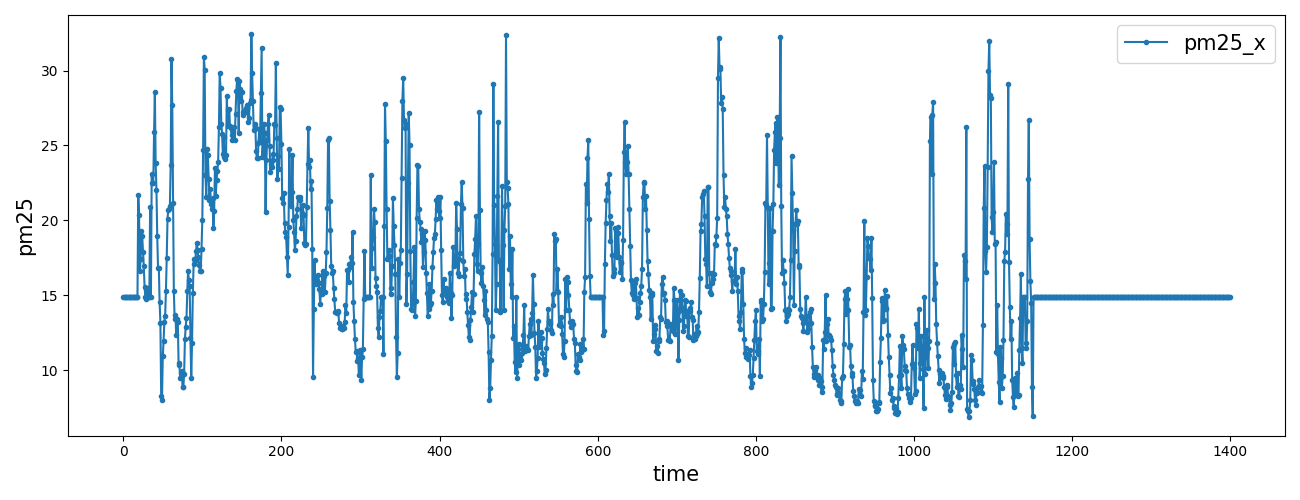

Handling for index 1


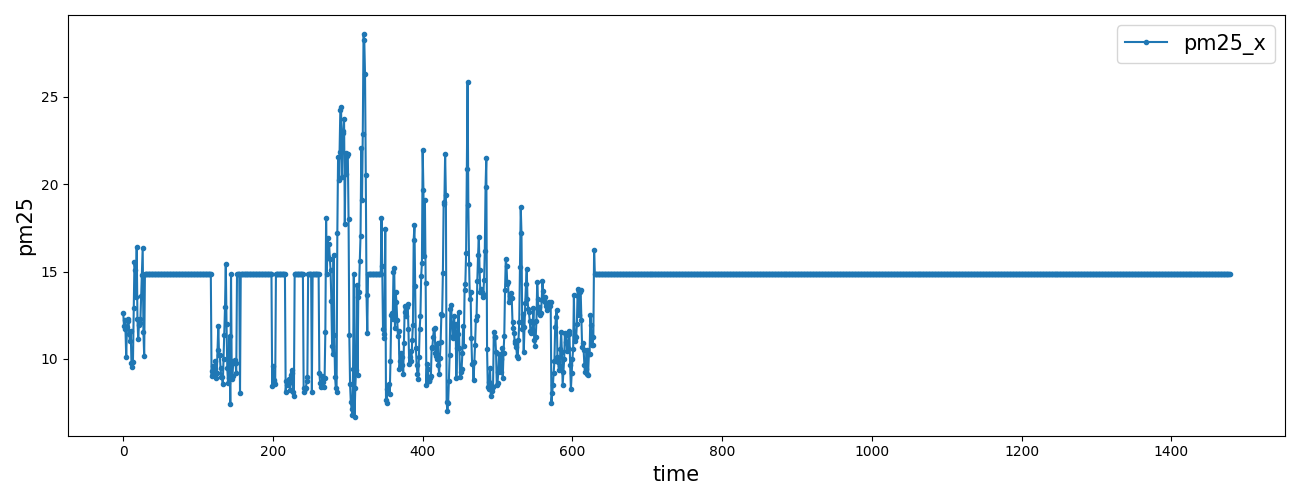

Handling for index 2


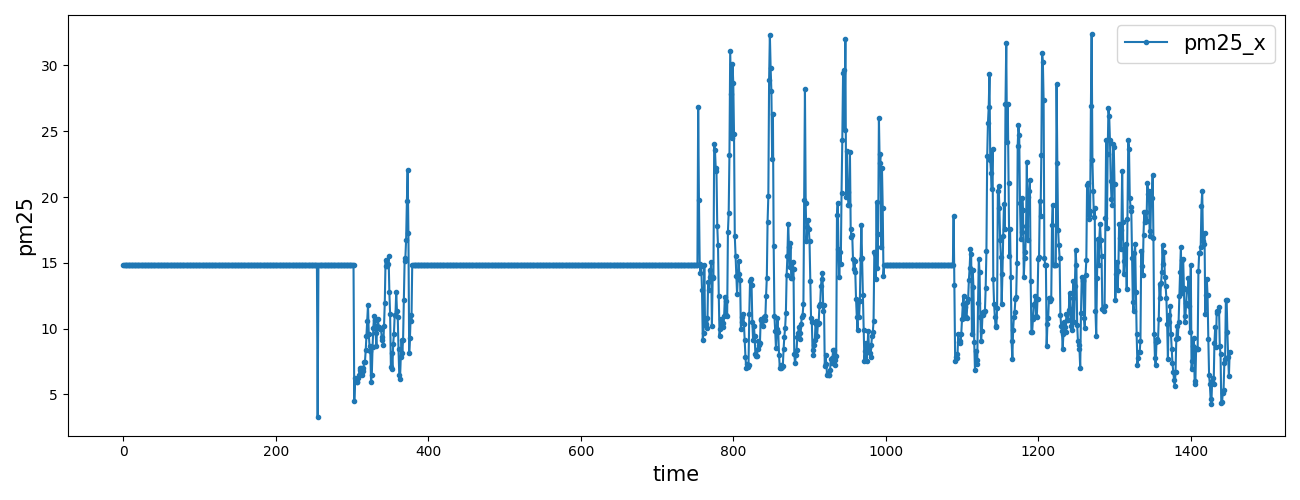

Handling for index 3


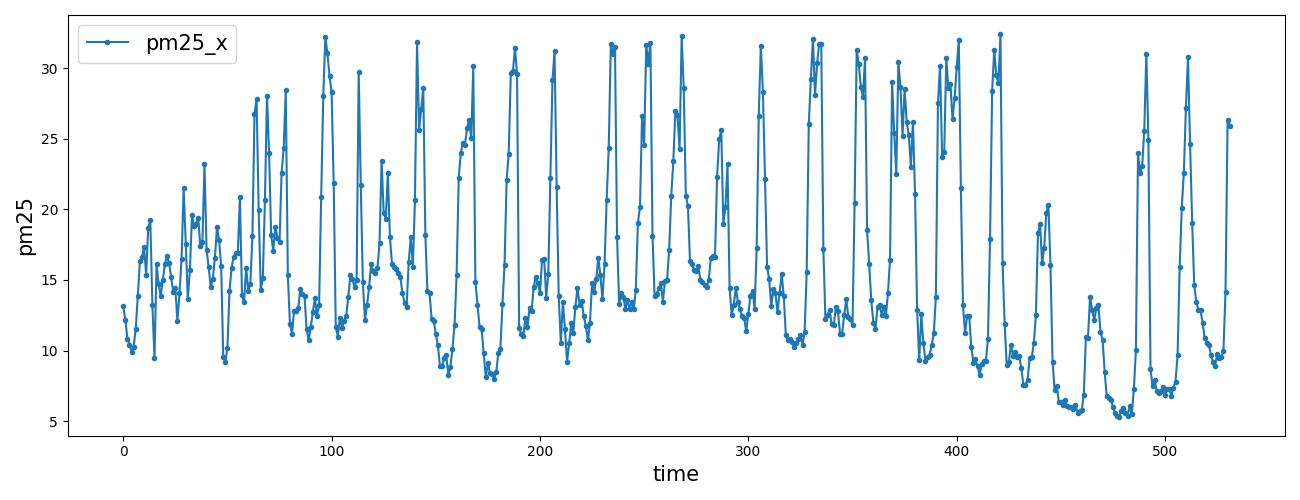

In [5]:
for idx, (feature, label) in datadict.items():
    print(f"Handling for index {idx}")
    plot_1_data(data=feature["pm25_x"],
                datalabel="pm25_x",
                xlabel="time",
                ylabel="pm25")

## Preprocessing

In [6]:
X = pd.concat([feature for (feature, _) in datadict.values()], axis=0).drop(columns=["pm25_x"])
y = pd.concat([label for (_, label) in datadict.values()], axis=0)
display(X)
display(y)

,station_distance,hour_cos,hour_sin
date,,,
2021-04-01 00:00:00,0.0,1.000000e+00,0.000000
2021-04-01 01:00:00,0.0,9.659258e-01,0.258819
2021-04-01 02:00:00,0.0,8.660254e-01,0.500000
2021-04-01 03:00:00,0.0,7.071068e-01,0.707107
2021-04-01 04:00:00,0.0,5.000000e-01,0.866025
...,...,...,...
2022-01-26 05:00:00,0.0,2.588190e-01,0.965926
2022-01-26 06:00:00,0.0,6.123234e-17,1.000000
2022-01-26 07:00:00,0.0,-2.588190e-01,0.965926


,pm25_y
date,
2021-04-01 00:00:00,14.867356
2021-04-01 01:00:00,14.867356
2021-04-01 02:00:00,14.867356
2021-04-01 03:00:00,14.867356
2021-04-01 04:00:00,14.867356
...,...
2022-01-26 05:00:00,9.533333
2022-01-26 06:00:00,9.966667
2022-01-26 07:00:00,14.133333


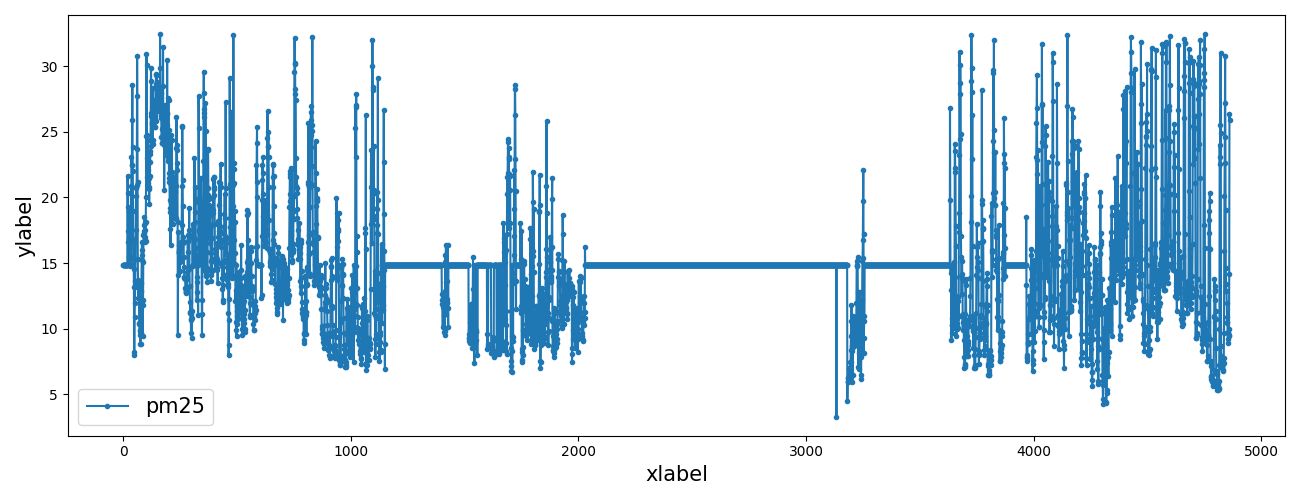

In [7]:
plot_1_data(data=y, datalabel="pm25")

### Data normalization

In [8]:
# Scaled features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,station_distance,hour_cos,hour_sin
0,0.0,1.000000,0.500000
1,0.0,0.982963,0.629410
2,0.0,0.933013,0.750000
3,0.0,0.853553,0.853553
4,0.0,0.750000,0.933013
...,...,...,...
4858,0.0,0.629410,0.982963
4859,0.0,0.500000,1.000000
4860,0.0,0.370590,0.982963
4861,0.0,0.250000,0.933013


In [9]:
# Scaled label
label_scaler = MinMaxScaler()
y_scaled = label_scaler.fit_transform(y)
y_scaled = pd.DataFrame(y_scaled, columns=y.columns)
y_scaled

,pm25_y
0,0.396851
1,0.396851
2,0.396851
3,0.396851
4,0.396851
...,...
4858,0.213730
4859,0.228607
4860,0.371651
4861,0.790486


## Dimensionality Reduction Comparation

### Evaluation board

In [10]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': [], 'n_future': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'n_future': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': [],
 'mnbe': [],
 'r_coeff': [],
 'p_value': []}

### Model paramaters

In [11]:
n_past = 168
n_future = 4
n_features = 1
n_label = 1
latent_dim = 32

epochs = 200
batch_size = 128

In [12]:
# Calculate MNBE
def mean_normalized_bias_error(y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return np.mean((y_pred - y_actual) / np.mean(y_actual)) * 100

metrics_calculators = {
    "mae": mean_absolute_error,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "r2": r2_score,
    "mape": mean_absolute_percentage_error,
    "mnbe": mean_normalized_bias_error,
    "r_coeff": lambda a,b: pearsonr(a, b)[0]
}

### Train test split

In [13]:
data = copy.deepcopy(y_scaled)

n = len(data)
train_indicator = round(0.8 * n)
train_data = data[:train_indicator]
test_data = data[train_indicator:]

X_train, y_train = reframePastFuture(train_data, n_past, n_future, keep_label_only=True)
X_test, y_test = reframePastFuture(test_data, n_past, n_future, keep_label_only=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3719, 168, 1) (3719, 4, 1) (802, 168, 1) (802, 4, 1)


### LSTM-Seq2Seq Attention

In [21]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_lstm_1 = LSTM(128, return_sequences=True, activation="relu")(encoder_inputs)
encoder_lstm_2, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_lstm_1)
encoder_dropout = Dropout(0.2)(encoder_lstm_2)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_lstm_2 = LSTM(128, return_sequences=True, activation="relu")(decoder_lstm_1)
decoder_attention = Attention()([decoder_lstm_1, decoder_lstm_2])
decoder_dropout = Dropout(0.2)(decoder_attention)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)

# Compile the model
lstms2smodel = Model(encoder_inputs, decoder_outputs)
lstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(lstms2smodel.summary())

# Fit model
history = lstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = lstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

(None, 64)
(None, 168, 64)
(None, 32)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 168, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 168, 128)  │     66,560 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ [(None, 64),      │     49,408 │ lstm_14[0][0]     │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 4, 32)     │          0 │ dense_7[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 4, 64)     │     24,832 │ repeat_vector_6[… │
│                     │                   │            │ lstm_15[0][1],    │
│                     │                   │            │ lstm_15[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 4, 128)    │     98,816 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_8         │ (None, 4, 128)    │          0 │ lstm_16[0][0],    │
│ (Attention)         │                   │            │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 4, 128)    │          0 │ attention_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 1)      │        129 │ dropout_8[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 241,825 (944.63 KB)

 Trainable params: 241,825 (944.63 KB)

 Non-trainable params: 0 (0.00 B)

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/200


ValueError: Exception encountered when calling Attention.call().

[1mDimensions must be equal, but are 64 and 128 for '{{node functional_1/attention_8_1/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false, grad_x=false, grad_y=false](functional_1/lstm_16_1/transpose_1, functional_1/attention_8_1/transpose)' with input shapes: [?,4,64], [?,128,4].[0m

Arguments received by Attention.call():
  • inputs=['tf.Tensor(shape=(None, 4, 64), dtype=float32)', 'tf.Tensor(shape=(None, 4, 128), dtype=float32)']
  • mask=['None', 'None']
  • training=True
  • return_attention_scores=False
  • use_causal_mask=False

In [ ]:
stop

### LSTM-Seq2Seq

In [ ]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_lstm_1 = LSTM(128, return_sequences=True, activation="relu")(encoder_inputs)
encoder_lstm_2, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_lstm_1)
encoder_dropout = Dropout(0.2)(encoder_lstm_2)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_lstm_2 = LSTM(128, return_sequences=True, activation="relu")(decoder_lstm_1)
decoder_dropout = Dropout(0.2)(decoder_lstm_2)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
lstms2smodel = Model(encoder_inputs, decoder_outputs)
lstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(lstms2smodel.summary())

# Fit model
history = lstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = lstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

### GRU-Seq2Seq

In [ ]:
# encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_gru_1 = GRU(128, return_sequences=True, activation="relu")(encoder_inputs)
encoder_gru_2, state_h = GRU(64, return_state=True, activation="relu")(encoder_gru_1)
encoder_dropout = Dropout(0.2)(encoder_gru_2)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_gru_1 = GRU(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=state_h)
decoder_gru_2 = GRU(128, return_sequences=True, activation="relu")(decoder_gru_1)
decoder_dropout = Dropout(0.2)(decoder_gru_2)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
grus2smodel = Model(encoder_inputs, decoder_outputs)
grus2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(grus2smodel.summary())

# Fit model
history = grus2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = grus2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

### CNN-LSTM Seq2seq

In [ ]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_cnn_1 = Conv1D(filters=128, kernel_size=2, activation="relu")(encoder_inputs)
encoder_max_pooling_1 = MaxPooling1D(pool_size=2)(encoder_cnn_1)
encoder_cnn_2 = Conv1D(filters=64, kernel_size=2, activation="relu")(encoder_max_pooling_1)
encoder_max_pooling_2 = MaxPooling1D(pool_size=2)(encoder_cnn_2)
encoder_lstm, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_max_pooling_2)
encoder_dropout = Dropout(0.2)(encoder_lstm)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_dropout = Dropout(0.2)(decoder_lstm_1)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
cnncnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
# Compile the model
cnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
cnnlstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(cnnlstms2smodel.summary())

# Fit model
history = cnnlstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    #EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = cnnlstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

## Evaluation board

In [ ]:
pd.DataFrame(evaluation_board)